# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [124]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math

np.random.seed(0)
torch.manual_seed(0)
torch.set_printoptions(precision=3, sci_mode=True)

In [159]:
## ======================== Parameters ========================
d1 = 2500                   # num. of rows
d2 = 2300                   # num. of columns
ths_sparse_init = 5e-2      # initial value of threshold for sparse component
# ths_sv_init = 1e-3        # initial value of threshold for singular values
max_iter = 100              # num. of layers trained
r = 5
alpha = 0.4

In [157]:
## Code to generate data for RPCA problem. References:
## https://github.com/caesarcai/LRPCA/blob/main/synthetic_data_exp/training_codes.py 
## https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/test_AccAltProj.m

def generate_problem(r,d1,d2,alpha, c):
    U0_t 		= torch.randn(d1,r)
    V0_t 		= torch.randn(d2,r)
    L0_t 		= U0_t @ V0_t.t()
    idx 		= torch.randperm(d1*d2)
    idx 		= idx[:math.floor(alpha * d1*d2)]
    s_range		= c * torch.mean(torch.abs(L0_t))
    S0_tmp 		= torch.rand(d1 * d2)
    S0_tmp 		= s_range * (2.0 * S0_tmp - 1.0)
    S0_t        = torch.zeros(d1 * d2)
    S0_t[idx]   = S0_tmp[idx]
    S0_t        = S0_t.reshape((d1,d2))
    Y0_t        = L0_t + S0_t
    return L0_t, S0_t, Y0_t

## Classical

In [126]:
def thres(inputs, threshold, hard=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- threshold, torch.zeros([1,1]))
    else:
        out = torch.sign(inputs) * (nn.Threshold(threshold, 0)(torch.abs(inputs)))
    return out

def AccAltProj(M0, r, tol, gamma, max_iter):
    m, n = M0.shape
    norm_of_M0 = torch.linalg.norm(M0)
    ## Keep track of loss
    loss = []
    ## Initialization
    beta = 1/(2 * np.power(m * n, 1/4))
    beta_init = 4 * beta
    zeta = beta_init * torch.linalg.norm(M0, 2)
    S = thres(M0, zeta)#, False)
    U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
    ## NOTE: torch.linalg.svd(M) returns U, S, V such that M=USV not USV.T
    U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
    L = U @ torch.diag(Sigma) @ V.t()
    zeta = beta * Sigma[0]
    S = thres(M0 - L, zeta)#, False)
    ## Initial loss
    err = torch.linalg.norm(M0 - L - S)/ norm_of_M0
    loss.append(err)
    for t in range(max_iter):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0)
        Um, Sigma, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sigma[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sigma[r] + torch.pow(gamma, t + 1) * Sigma[0])
        S = thres(M0 - L, zeta)#, False)
        ## Compute error
        err = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        loss.append(err)
        if err < tol:
            return loss, L, S
    return loss, L, S

In [127]:
## generate data
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha, c=1)

In [135]:
## start with M_true, assuming known rank
## error tolerance = 1e-6, gamma = 0.5, max_iter = 100
loss, L_hat, S_hat = AccAltProj(M_true, r, 1e-6, torch.tensor(0.7), max_iter)

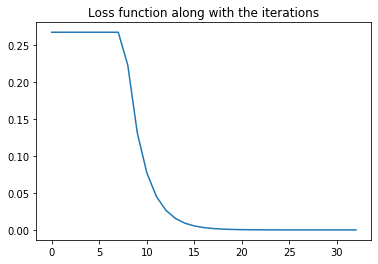

tensor(7.508e-07)
tensor(6.577e-07)
tensor(4.038e-06)


In [136]:
plt.plot(loss)
plt.title('Loss function along with the iterations')
plt.show()

print(loss[-1])
print(torch.linalg.norm(L_hat - L_true)/ torch.linalg.norm(L_true))
print(torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

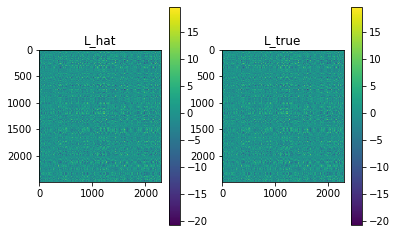

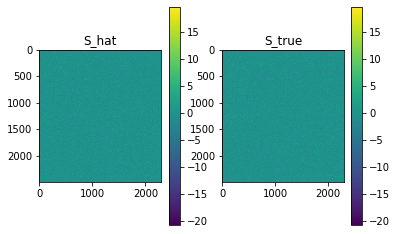

In [137]:
combined = torch.cat((L_hat, L_true, S_hat, S_true)) ## combine matrices so that colorbars can be standardized

fig, [ax1, ax2] = plt.subplots(1,2)
im1 = ax1.imshow(L_hat, vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("L_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(L_true, vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("L_true")
plt.colorbar(im2, ax=ax2)
plt.show()

fig, [ax1, ax2] = plt.subplots(1,2)
im1 = ax1.imshow(S_hat, vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("S_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(S_true, vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("S_true")
plt.colorbar(im2, ax=ax2)
plt.show()

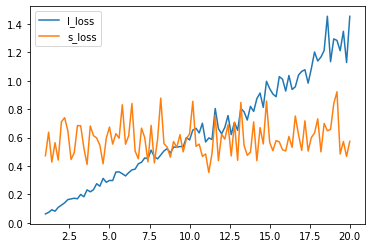

In [138]:
## Non-zero entries of sparse component S are drawn i.i.d. from the uniform distribution
## over the interval [-c*E(|[L]_ij|), c*E(|[L]_ij|)] for some constant c > 0.
## This part is just looking at how c affects the approximation of L and S in this algorithm.
con = np.arange(1,20.2,0.2)
l_loss = []
s_loss = []
for c in con:
    L0, S0, M0 = generate_problem(2, 100, 70, alpha, c)
    loss, L1, S1 = AccAltProj(M0, r, 1e-6, torch.tensor(0.7), 100)
    l_loss.append(torch.linalg.norm(L0 - L1)/ torch.linalg.norm(L0))
    s_loss.append(torch.linalg.norm(S0 - S1, 1)/ torch.linalg.norm(S0, 1))
plt.plot(con, l_loss, label = "l_loss")
plt.plot(con, s_loss, label = "s_loss")
plt.legend()
plt.show()

## Unrolled version

In [155]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class LearnedAAP(nn.Module):
    def __init__(self, max_iter):
        super().__init__()
        self.max_iter = max_iter
        #self.ths_sparse = nn.ParameterList([nn.Parameter(torch.tensor(ths_sparse_init)) for t in range(max_iter)])
        #self.ths_sv = nn.ParameterList([nn.Parameter(torch.tensor(ths_sv_init)) for t in range(max_iter + 1)])
        self.gamma = nn.ParameterList([nn.Parameter(torch.tensor(0.5)) for t in range(max_iter)])
        self.loss = np.zeros(max_iter)

    ## thresholding operator
    def thres(self, inputs, threshold, hard=True):
        if not hard:
            out = torch.sign(inputs) * torch.max(torch.abs(inputs)- threshold, torch.zeros([1,1]))
        else:
            out = inputs * (torch.abs(inputs) > threshold)
        return out

    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        ## Initialization
        ## 1. this part follows the parameter value used in matlab code
        beta = 1/(2 * np.power(m * n, 1/4)) # 
        beta_init = 4 * beta
        ## 2. next 7 lines follows Algorithm (3) in Page 7 of the paper
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = self.thres(M0, zeta)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = self.thres(M0 - L, zeta)
        ## Main loop, follows Algorithm (1) in Page 5 of the paper
        for t in range(self.max_iter):
            # no trimming step here
            # print(list(self.ths_sparse))
            #U, Sigma, V = self.proj(M0 - S, U, V, r) # calculate projection
            #L = U @ torch.diag(Sigma) @ V.t()
            #S = self.softThres(M0 - L, self.ths_sparse[t])
            #self.loss[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0

            Z = M0 - S
            Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
            Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
            A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                            torch.cat((R2, torch.zeros(R2.shape)), 1)), 0)
            Um, Sigma, Vm = torch.linalg.svd(A, full_matrices=False)
            U = torch.cat((U, Q2), 1) @ Um[:,:r]
            V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
            L = U @ torch.diag(Sigma[:r]) @ V.t()
            ## Update S
            zeta = beta * (Sigma[r] + torch.pow(self.gamma[t], t + 1) * Sigma[0])
            S = self.thres(M0 - L, zeta)

            self.loss[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

In [160]:
## ======================== Parameters ========================
d1 = 100                   # num. of rows
d2 = 70                   # num. of columns
ths_sparse_init = 5e-2      # initial value of threshold for sparse component
# ths_sv_init = 1e-3        # initial value of threshold for singular values
max_iter = 50              # num. of layers trained
r = 2
alpha = 0.4

In [161]:
## generate data
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha, c=1)

In [162]:
## ======================== Training ========================
net = LearnedAAP(max_iter)
beforetrain=net(M_true, r) # assumes knowledge of rank
lossbftrain=np.array(net.loss)

In [165]:
optimizer=Adam(net.parameters()) # Adam algorithm will be learned to optimise paramaters

nepochs = 20

for epoch in range(nepochs):

    for i in range(100):
        # get the inputs
        print("epoch", epoch, ", ", i)
        L0, S0, M0 = generate_problem(r, d1, d2, alpha, c=1)
        optimizer.zero_grad()
        L_hat, S_hat = net(M0, r)
        loss = torch.linalg.norm(M0 - L_hat - S_hat)/ torch.linalg.norm(M0)
        loss.backward()
        optimizer.step()
    
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(round(loss.item(),3)))

print('Finished Training')

epoch 0 ,  0


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
L_hat, S_hat = net(M_true, 2)
plt.plot(range(max_iter),net.loss,'r:',label='Loss after training')
plt.plot(range(max_iter),lossbftrain,label='Loss before training')